<a href="https://colab.research.google.com/github/Harshita9511/A-Comparative-Analysis-of-Recurrent-Neural-Networks-and-1D-Convolution-on-IMDb-Movie-Review-Dataset/blob/master/ML_Sentiment_Analysis_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
df_train=pd.read_csv("train_dataset.csv")
df_train.head()

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


In [0]:
df_test=pd.read_csv("test_dataset.csv")
df_test.head()

,id,tweet
0,7921,I hate the new #iphone upgrade. Won't let me d...
1,7922,currently shitting my fucking pants. #apple #i...
2,7923,"I'd like to puts some CD-ROMS on my iPad, is t..."
3,7924,My ipod is officially dead. I lost all my pict...
4,7925,Been fighting iTunes all night! I only want th...


In [0]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import string
from string import punctuation

df_train['tweet'] = df_train['tweet'].str.translate(str.maketrans('','', string.punctuation))
df_test['tweet'] = df_test['tweet'].str.translate(str.maketrans('','', string.punctuation))

def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet
# ______________________________________________________________
# clean dataframe's text column
df_train['text'] = df_train['tweet'].apply(processTweet)
df_test['text'] = df_test['tweet'].apply(processTweet)

# tokenize helper function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    sw= [word.lower() for word in nopunc.split() if word not in stopwords.words('english')]
    return ' '.join(sw)

df_train['text'] = df_train['text'].apply(text_process)
df_test['text'] = df_test['text'].apply(text_process) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
df_train['Rating_Polarity'] = df_train['label'].apply(lambda x: 'Positive' if x==0  else 'Negative')

Random over-sampling:
Negative    5894
Positive    5894
Name: Rating_Polarity, dtype: int64


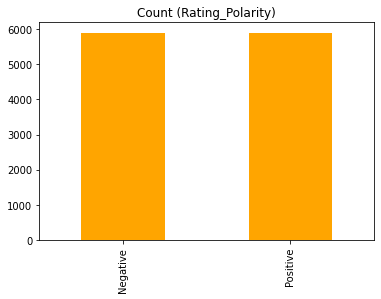

In [0]:
df_class_Positive = df_train[df_train['Rating_Polarity'] == 'Positive']
df_class_Negative = df_train[df_train['Rating_Polarity'] == 'Negative']

df_class_Negative_over = df_class_Negative.sample(len(df_class_Positive), replace=True)
df_train = pd.concat([df_class_Positive, df_class_Negative_over], axis=0)

print('Random over-sampling:')
print(df_train['Rating_Polarity'].value_counts())

df_train['Rating_Polarity'].value_counts().plot(kind='bar', title='Count (Rating_Polarity)', color='orange');

In [0]:
np.random.seed(42)

In [0]:
from sklearn.utils import shuffle
df_train = shuffle(df_train, random_state=42)
df_train.head()

,id,label,tweet,text,Rating_Polarity
2811,2812,1,As the saying goes google is going to rue the...,saying goes google going rue day decided work ...,Negative
3008,3009,1,timcook should slap the CEO of BlackBerry for ...,timcook slap ceo blackberry audacity campaign ...,Negative
3706,3707,0,Merry Christmas Big switch I can take nice pho...,merry christmas big switch take nice photos sa...,Positive
2573,2574,0,Welcome to IG World Hehehe restday instagram p...,welcome world hehehe restday instagram picofth...,Positive
6423,6424,1,The Fucking Mac Calendar 1 Is Now Off Fucking ...,fucking mac calendar fucking center httpdlvrit...,Negative


In [0]:
X_train=df_train['text'].values
y_train=df_train['label'].values

X_test=df_test['text'].values

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

vect= CountVectorizer(min_df=5, ngram_range=(1,2))
X_train=vect.fit_transform(X_train)
X_test=vect.transform(X_test)

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf=TfidfTransformer()
X_train=tfidf.fit_transform(X_train)
X_test=tfidf.transform(X_test)

In [0]:
from sklearn import svm
model_svm = svm.SVC(kernel='linear', probability=True, random_state=42)
model_svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
X_train_arr= X_train.toarray()
X_test= X_test.toarray()

from sklearn.naive_bayes import MultinomialNB
model_mnb = MultinomialNB()
model_mnb.fit(X_train_arr, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
from sklearn.naive_bayes import ComplementNB
model_cnb = ComplementNB()
model_cnb.fit(X_train_arr, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [0]:
from sklearn.ensemble import BaggingClassifier
model_bagg_cnb = BaggingClassifier(ComplementNB(), max_samples=0.5, max_features=0.5, random_state=42)
model_bagg_cnb.fit(X_train, y_train)

model_bagg_mnb = BaggingClassifier(MultinomialNB(), max_samples=0.5, max_features=0.5, random_state=42)
model_bagg_mnb.fit(X_train, y_train)

BaggingClassifier(base_estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                               fit_prior=True),
                  bootstrap=True, bootstrap_features=False, max_features=0.5,
                  max_samples=0.5, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

In [0]:
from sklearn.ensemble import VotingClassifier

estimators=[('SVM', model_svm), ('LR', model_lr), ('Multinomial NB', model_mnb), ('Complement NB', model_cnb), ('Bagging Complement NB ', model_bagg_cnb), ('Bagging MultinomialNB', model_bagg_mnb)]

weighted_avg_voting = VotingClassifier(estimators, voting='soft', weights=[2, 1, 3, 4, 3, 3])
weighted_avg_voting.fit(X_train, y_train)

majority_voting = VotingClassifier([('SVM', model_svm), ('LR', model_lr), ('Multinomial NB', model_mnb), ('Complement NB', model_cnb), ('Bagging Complement NB ', model_bagg_cnb), ('Bagging MultinomialNB', model_bagg_mnb), ('Weighted Average Voting', weighted_avg_voting)], voting='hard')
majority_voting.fit(X_train, y_train)


VotingClassifier(estimators=[('SVM',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=True, random_state=42,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('LR',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_...
                                                            BaggingClassifier(base_estimator=MultinomialNB(alpha=1.0,
                                                                                                           class_prior=None,
                         

In [0]:
df_test['label']=majority_voting.predict(X_test)

In [0]:
submission=df_test[['id', 'label']].to_csv('submission.csv', index=False)